# Lab 7 - Infotaxis
(aka- pure curiosity-driven search)

Here we will explore how our little artificial organisms do two things:

1. Learn a *concept* of information as a signal. This reflects the curiosity about a signal, as opposed to its magnitude.
2. How this concept of information facilitates learning in noisy environments.

## Background

In this lab we return to _taxic explorations_. Recall that in Lab 4 (evidence accumulation) we look at what happens when sense information is not just noisy, but partially observed. In otherwords, when there is distortion in the channel of information.

Here we will compare the simple chemotaxic framework, where agents simply follow the gradient of the scent, to an _infotaxic_ framework where agents follow the _information_ carried in the signal instead.



Recall that our basic model of valentino exploration is as simple as can be.

- When the gradient is positive, meaning you are going "up" the gradient, the probability of turning is set to _p pos_.
- When the gradient is negative, the turning probability is set to _p neg_. (See code below, for an example).
- If the agent "decides" to turn, the direction it takes is uniform random.
- The length of travel before the next turn decision is sampled from an exponential distribution just like the _DiffusionDiscrete_

### Information agents
We will study three agents. One who does _chemotaxis_. One who does a kind of _infotaxis_. One that does random search (aka Diffusion). For fun, let's call this one a _randotaxis_ agent. This last rando-agent is really a control. A reference point.

In a sense the _chemotaxis_ agent only tries to answer question Q2 (above). While _infotaxis_ only tries to answer Q1. They are extreme strategies, in other words. The bigger question we will ask, in a very limited setting, is which extreme method is better _generally_?


### Costly cognition
Both _chemo-_ and _infotaxis_ agents will use a simple accumulation-of-evidence process to try and make better decisions about the direction of the gradient. These decisions are of course statistical in nature.

Our control agent, _randotaxis_, will be another simple Brownian random walk agent.


## Reviewing the definition of _chemotaxis_:
Our _chemotaxis_ agent (_GradientDiffusionGrid_) tries to directly estimate the gradient $\nabla$ in scent by comparing the level of scent at the last grid position it occupied to the current scent level ($o$). By last grid position here we mean the last grid position when it moved last.

$$\nabla \approx o_t - o_{t-1}$$

For today we're going back to the simple, non-accumulator chemotaxic agent that uses the simple gradient to make a decision about running vs. tumbling.

## A definition of _infotaxis_:
Compared to chemo- definition the definition of infotaxis is a little more involved. It has what we can think of as five cognitive or behavioral steps:

1. Use a simple differntial to estimate whether the gradient is increasing or decreasing.

2. Build a probability model of hits(increasing)/misses(decreasing) at every point of the grid.
3. Measure information gained when probability model changes. This is quantified using the KL divergence that measures how the properties of the signal are changing.
4. Measure the gradient of information gains
5. Use the gradient to make turning decisions

_Note_: Even though the infotaxis is more complex, it can take advantage of missing scent information to drive its behavior. It can also use positive scent hits, of course, too.


## Section 0 - Setup

First let's set things up for the two parts of the lab. You've done this before, so we don't need to specify each installation and module step.

In [12]:
!pip install --upgrade git+https://github.com/coaxlab/explorationlib
!pip install --upgrade git+https://github.com/MattChanTK/gym-maze.git

  Cloning https://github.com/coaxlab/explorationlib to /tmp/pip-req-build-xcjr85g1
  Running command git clone --filter=blob:none --quiet https://github.com/coaxlab/explorationlib /tmp/pip-req-build-xcjr85g1
  Resolved https://github.com/coaxlab/explorationlib to commit 6ed899dafd40d0c87bf5fd1d44e0af610b8eab75
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/MattChanTK/gym-maze.git to /tmp/pip-req-build-r621adiy
  Running command git clone --filter=blob:none --quiet https://github.com/MattChanTK/gym-maze.git /tmp/pip-req-build-r621adiy
  Resolved https://github.com/MattChanTK/gym-maze.git to commit 83176811b49b5538a6213520612f44fb1bc49114
  Preparing metadata (setup.py) ... done


In [13]:
import shutil
import glob
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy

import explorationlib
from explorationlib.local_gym import ScentGrid

from explorationlib.agent import DiffusionGrid
from explorationlib.agent import GradientDiffusionGrid
from explorationlib.agent import GradientInfoGrid

from explorationlib.run import experiment
from explorationlib.util import select_exp
from explorationlib.util import load
from explorationlib.util import save

from explorationlib.local_gym import uniform_targets
from explorationlib.local_gym import constant_values
from explorationlib.local_gym import ScentGrid
from explorationlib.local_gym import create_grid_scent
from explorationlib.local_gym import add_noise
from explorationlib.local_gym import create_grid_scent_patches

from explorationlib.plot import plot_position2d
from explorationlib.plot import plot_length_hist
from explorationlib.plot import plot_length
from explorationlib.plot import plot_targets2d
from explorationlib.plot import plot_scent_grid
from explorationlib.plot import plot_targets2d

from explorationlib.score import total_reward
from explorationlib.score import num_death

In [14]:
# Pretty plots
%matplotlib inline
%config InlineBackend.figure_format='retina'
%config IPCompleter.greedy=True
plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["font.size"] = "16"

# Dev
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Section 1 - Chemotaxis vs. curiosity

In this section we take on accumulating evidence as a policy for decision making. Our venue is still chemotaxis, but now our sensors are noisy. The presence of this uncertainty makes decisions--of the kind common to decision theory--a necessity.

Let's see just how helpful the concept of information for chemotaxic search can be.

In [17]:
# Noise and missing scents
p_scent = 0.5
noise_sigma = 1

# Shared
num_experiments = 100
num_steps = 500
seed_value = 5838

# ! (leave alone)
detection_radius = 1
max_steps = 1
min_length = 1
num_targets = 50
target_boundary = (10, 10)

# Targets
prng = np.random.RandomState(seed_value)
targets = uniform_targets(num_targets, target_boundary, prng=prng)
values = constant_values(targets, 1)

# Scents
scents = []
for _ in range(len(targets)):
    coord, scent = create_grid_scent_patches(
        target_boundary, p=1.0, amplitude=1, sigma=2)
    scents.append(scent)

# Env
env = ScentGrid(mode=None)
env.seed(seed_value)
env.add_scents(targets, values, coord, scents, noise_sigma=noise_sigma)

Again we are working a scent grid environment where each target emits noisy chemical signals (scents) according to our definitions above.

Here's an example of our environment

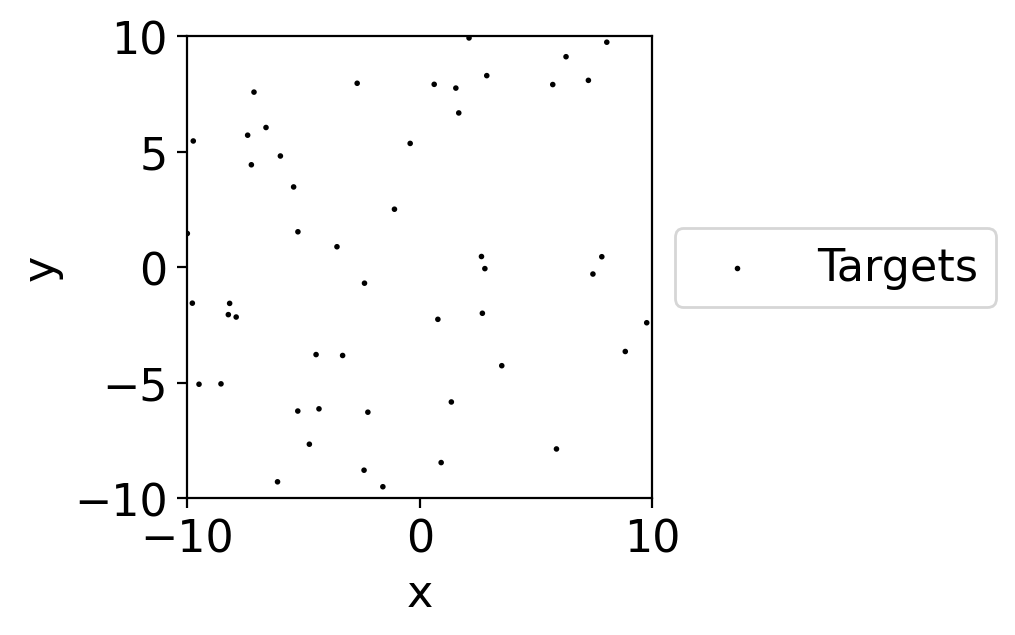

In [18]:
plot_boundary = (10, 10)
num_experiment = 0
ax = None
ax = plot_targets2d(
    env,
    boundary=plot_boundary,
    color="black",
    alpha=1,
    label="Targets",
    ax=ax,
)

We will use 3 agents in these sims:

- Rando: Uses random Brownian motion search.
- Chemo: Uses only the detected scent gradient to make a decision.
- Info: Estimates how much *information* is encoded in the scent signal to make a decision.

In [19]:
# Agents

# Random search agent
diff = DiffusionGrid(min_length=min_length)
diff.seed(seed_value)

# Run & tumble information
min_length = 1 # Minimum step length on the grid
p_neg = 0.8 # Probability of jumping if gradient/information is decreasing
p_pos = 0.2 # Probabilty of jumping if gradient/information is increasing

# Chemotaxis agent
chemo = GradientDiffusionGrid(
    min_length=min_length,
    p_neg=p_neg,
    p_pos=p_pos,
)
chemo.seed(seed_value)


# Infotaxis agent
threshold = 0.05 # Threshold for information gain
info = GradientInfoGrid(
    min_length=min_length,
    p_neg=p_neg,
    p_pos=p_pos,
    threshold=threshold
)
info.seed(seed_value)



[5838]

Now let's run the experiments.

In [20]:
# Experiments
rand_exp = experiment(
    f"rand",
    diff,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
    seed=seed_value
)
chemo_exp = experiment(
    f"chemo",
    chemo,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
    seed=seed_value
)
info_exp = experiment(
    f"info",
    info,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
    seed=seed_value
)

rand:   0%|          | 0/100 [00:00<?, ?it/s]

chemo:   0%|          | 0/100 [00:00<?, ?it/s]

info:   0%|          | 0/100 [00:00<?, ?it/s]

Let's plot an example experiment. Here I'm choosing the sixth run for each agent.

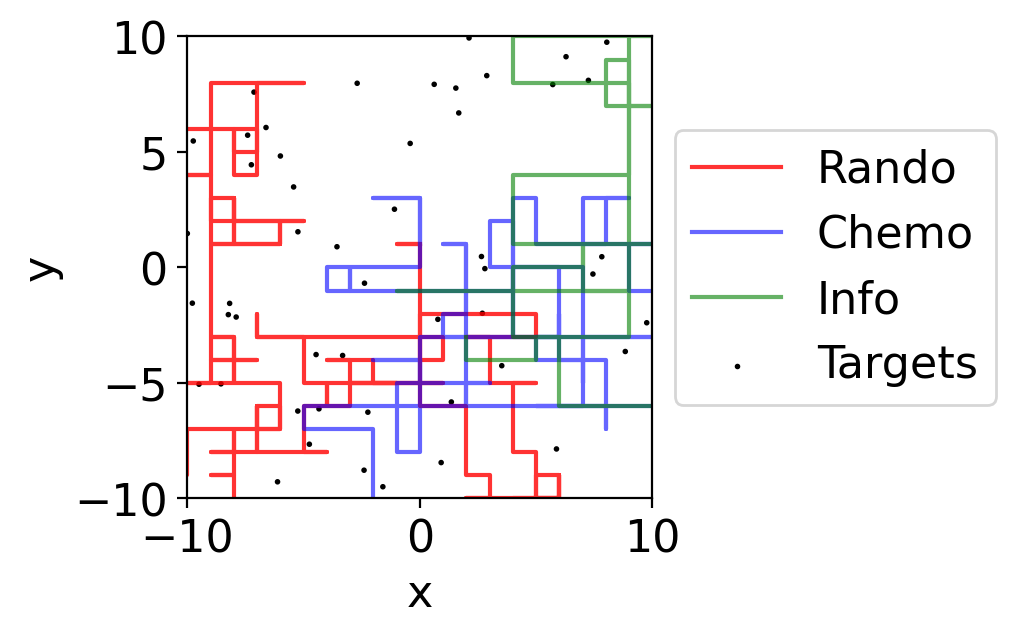

In [21]:
plot_boundary = (10, 10)

# -
num_experiment = 5
ax = None

ax = plot_position2d(
    select_exp(rand_exp, num_experiment),
    boundary=plot_boundary,
    label="Rando",
    color="red",
    alpha=0.8,
    ax=ax,
)
ax = plot_position2d(
    select_exp(chemo_exp, num_experiment),
    boundary=plot_boundary,
    label="Chemo",
    color="blue",
    alpha=0.6,
    ax=ax,
)
ax = plot_position2d(
    select_exp(info_exp, num_experiment),
    boundary=plot_boundary,
    label="Info",
    color="green",
    alpha=0.6,
    ax=ax,
)
ax = plot_targets2d(
    env,
    boundary=plot_boundary,
    color="black",
    alpha=1,
    label="Targets",
    ax=ax,
)

Hard to distinguish their individual behaviors, but our agents seem to be exploring.

Now let's evaluate some metrics of performance.

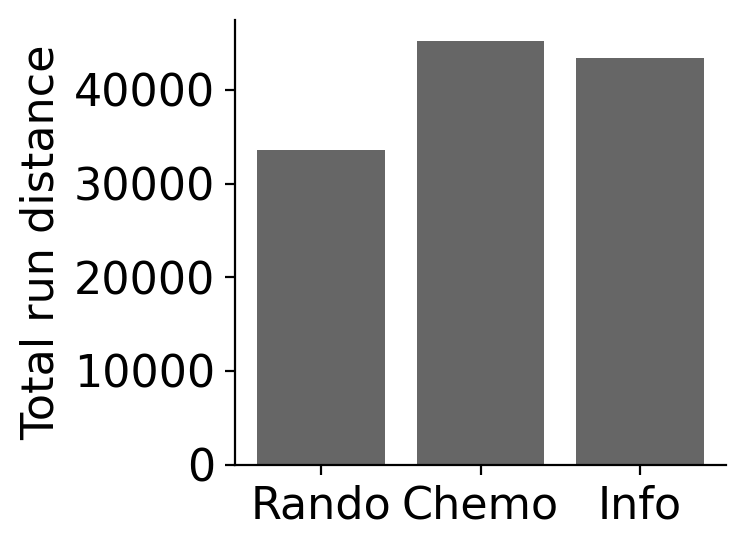

In [22]:
# Results
results = [rand_exp, chemo_exp, info_exp]
names = ["Rando", "Chemo", "Info"]
colors = ["red", "blue", "green"]

# Score by eff
scores = []
for name, res, color in zip(names, results, colors):
    l = 0.0
    for r in res:
        l += np.sum(r["agent_num_step"])
    scores.append(l)

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(4, 3))
plt.bar(names, m, yerr=sd, color="black", alpha=0.6)
plt.ylabel("Total run distance")
plt.tight_layout()
sns.despine()

num_death:   0%|          | 0/100 [00:00<?, ?it/s]

num_death:   0%|          | 0/100 [00:00<?, ?it/s]

num_death:   0%|          | 0/100 [00:00<?, ?it/s]

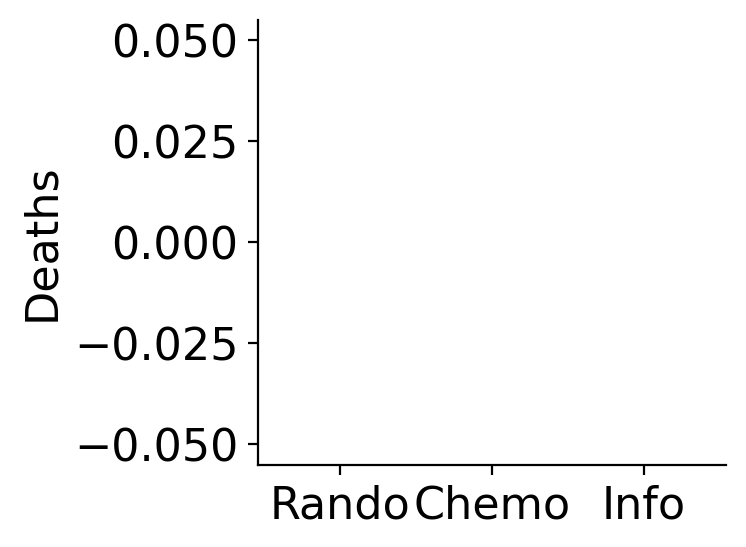

In [25]:
# Score by eff
scores = []
for name, res, color in zip(names, results, colors):
    scores.append(num_death(res))

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(4, 3))
plt.bar(names, m, yerr=sd, color="black", alpha=0.6)
plt.ylabel("Deaths")
plt.tight_layout()
sns.despine()

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

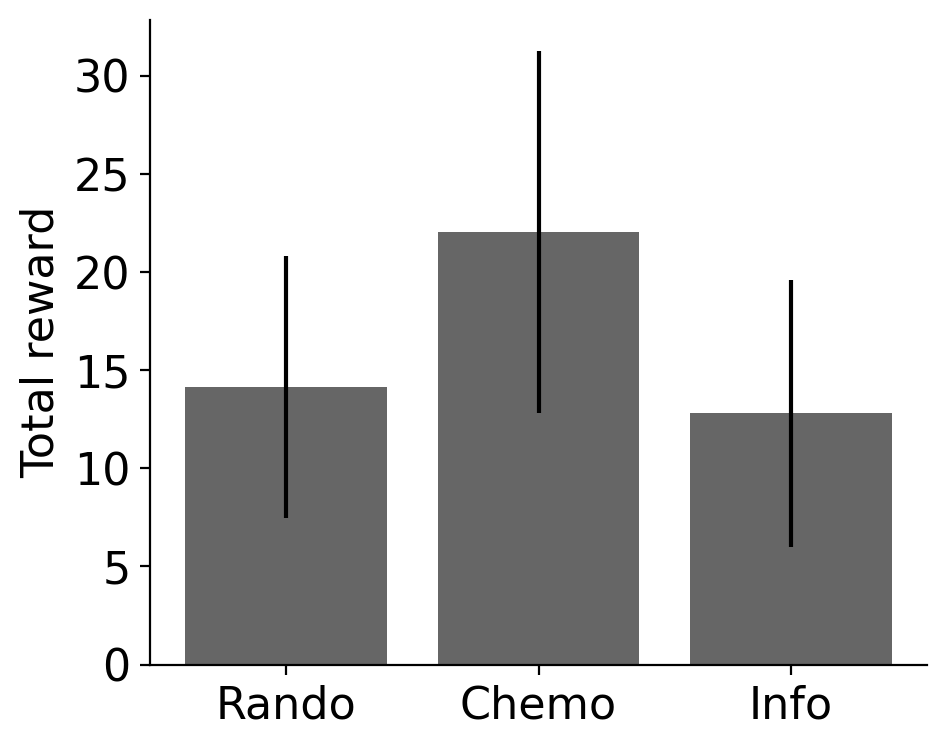

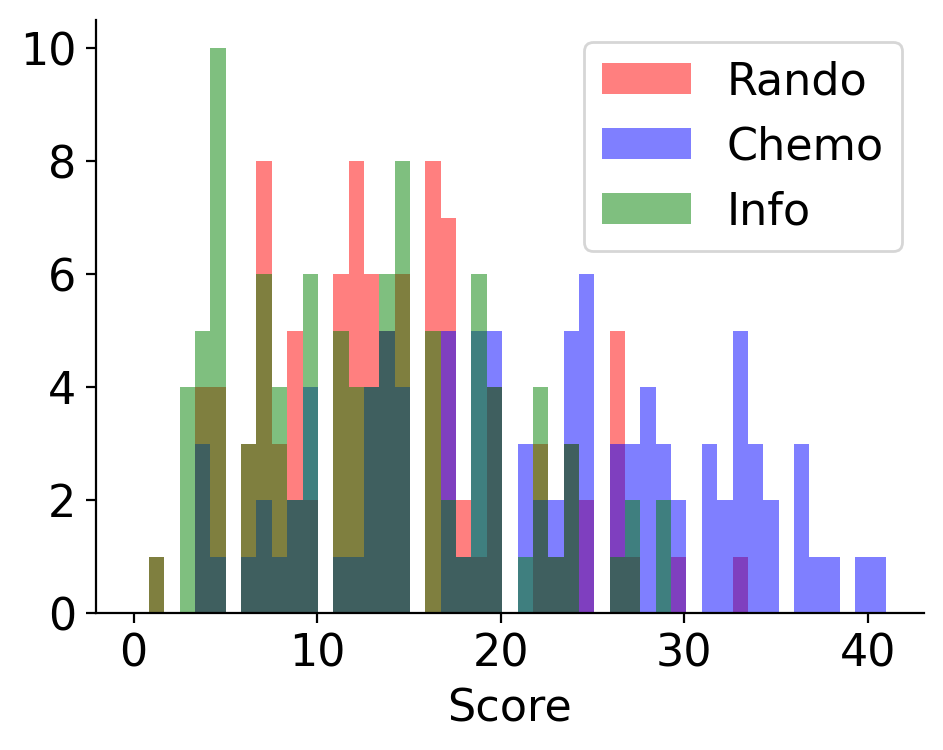

In [26]:
# Score by eff
scores = []
for name, res, color in zip(names, results, colors):
    r = total_reward(res)
    scores.append(r)

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(5, 4))
plt.bar(names, m, yerr=sd, color="black", alpha=0.6)
plt.ylabel("Total reward")
plt.tight_layout()
sns.despine()

# Dists
fig = plt.figure(figsize=(5, 4))
for (name, s, c) in zip(names, scores, colors):
    plt.hist(s, label=name, color=c, alpha=0.5, bins=np.linspace(0, np.max(scores), 50))
    plt.legend()
    plt.xlabel("Score")
    plt.tight_layout()
    sns.despine()

---
### Question 1.1

How does each of our agents perform across the performance measures we have chosen?

__Answer:__

Total Run Distance:

1. Rando Agent (red): The random agent covered the shortest distance overall.
2. Chemo Agent (blue): The chemotaxis agent had the longest total run distance.
3. Info Agent (green): The infotaxis agent's run distance was between Rando and Chemo.

Deaths:

1. The number of deaths for all agents appear to be roughly to the same with no significant deaths across Rando, Chemo, and Info agents.

Total Reward:

1. Rando agent: The random agent accumalated the lowest reward on average.
2. Chemo agent: The chemotaxis agent accumalated a reward lower than Chemo but higher than Rando.
3. Info agent: The infotaxis agent accumalated a reward lower than Chemo but higher than Rando.

Run Time:

1. Rando and Chemo agent: The random and chemotaxis agents both took around 40 seconds to run.
2. Info agent: The infotaxis agent took more than a minute longer to run.

Overall, the Chemo agent seems to perform the best in terms of both total run distance and reward, with the Info agent coming in second, and the Rando agent performing the worst in both categories. All agents performed similiarly regarding deaths (no deaths!). Lastly, the Info agent took more than a minute longer to run compared to the Chemo and Rando agents.


---
### Question 1.2

Is having a concept of information (i.e., the Info agent) helpful in these sorts of noisy environments? Why or why not based on how the agents performed? Compare to both Rando and Chemo.

__Answer:__

The Info agent, which uses concept of information to navigate, did not outperform the Chemo agent in terms of total reward or total run distance, indicating that in this specific noisy environment, following the scent gradient directly (as the Chemo agent does) was more effective.

However, the Info agent performed better than the Rando agent, which operated on random search without relying on information. This shows that even in an noisy environment, using a structured approach like information gain is better than random search. This is expected because random movement is less likely to efficently lead to rewards, while information-driven agents have a purpose in their movements.

Overall, while having a concept of information (Info agent) is helpful compared to a random search strategy (Rando), in this specific noisy environment, it is less effective than simply followin the scent gradient (Chemo). The added complexity of tracking information gain did not yield better results here, but the Info agent still performed reasonably well. This suggests that usefulness of information-based decision-making might actual depend on the specifics of the environment and noise levels.



## Section 2 - Robustness of information searching

You'll notice that the infotaxis agent has an additional parameter over the simple chemotaxis agent, which is it's threshold. This is needed because, unlike the scent gradient, the information gain (i.e., KL-divergence) gradient is bounded at zero. This determines how much information gain is necessary to trigger a shift.

Here we will test a range of *threshold* values (within the range of values our infotaxis agent is likely to see) and look at the change in performance.

In [27]:
# Our parameters
thresholds = [0.01, 0.025, .05, .075, .09]

# For plotting
colors = ["darkgreen", "seagreen", "cadetblue", "steelblue", "mediumpurple"]
names = thresholds

Let's run these experiments. All of the parameters for the agent and environment (aside from *p_scent*) are specified below.

In [28]:
# Define non-scent probability values
noise_sigma = 1
amplitude = 1
detection_radius = 1
max_steps = 1
min_length = 1
num_targets = 50
target_boundary = (10, 10)

# Define targets
prng = np.random.RandomState(seed_value)
targets = uniform_targets(num_targets, target_boundary, prng=prng)
values = constant_values(targets, 1)

# Scents
scents = []
for _ in range(len(targets)):
    coord, scent = create_grid_scent_patches(
        target_boundary, p=p_scent, amplitude=amplitude, sigma=noise_sigma)
    scents.append(scent)

# Env
env = ScentGrid(mode=None)
env.seed(seed_value)
env.add_scents(targets, values, coord, scents, noise_sigma=noise_sigma)

# How many experiments to run
num_experiments = 100

# Infotaxis agent
min_length = 1
p_neg = 0.8
p_pos = 0.2

# Run
results = []

for threshold in thresholds:

  # Setup our agent with a new threshold
  info = GradientInfoGrid(
      min_length=min_length,
      p_neg=p_neg,
      p_pos=p_pos,
      threshold=threshold
  )
  info.seed(seed_value)

  # Run the experiment
  exp = experiment(
    f"info",
    info,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
    seed=seed_value
  )
  results.append(exp)


info:   0%|          | 0/100 [00:00<?, ?it/s]

info:   0%|          | 0/100 [00:00<?, ?it/s]

info:   0%|          | 0/100 [00:00<?, ?it/s]

info:   0%|          | 0/100 [00:00<?, ?it/s]

info:   0%|          | 0/100 [00:00<?, ?it/s]

Now let us take a look at the performance. First let's see how the average information gain changes across runs of each experiment (i.e., threshold type). Remember, this is our first agent with a spatial memory and it carries over across runs. So we should see a decreasing trend as the agent learns the environment more.

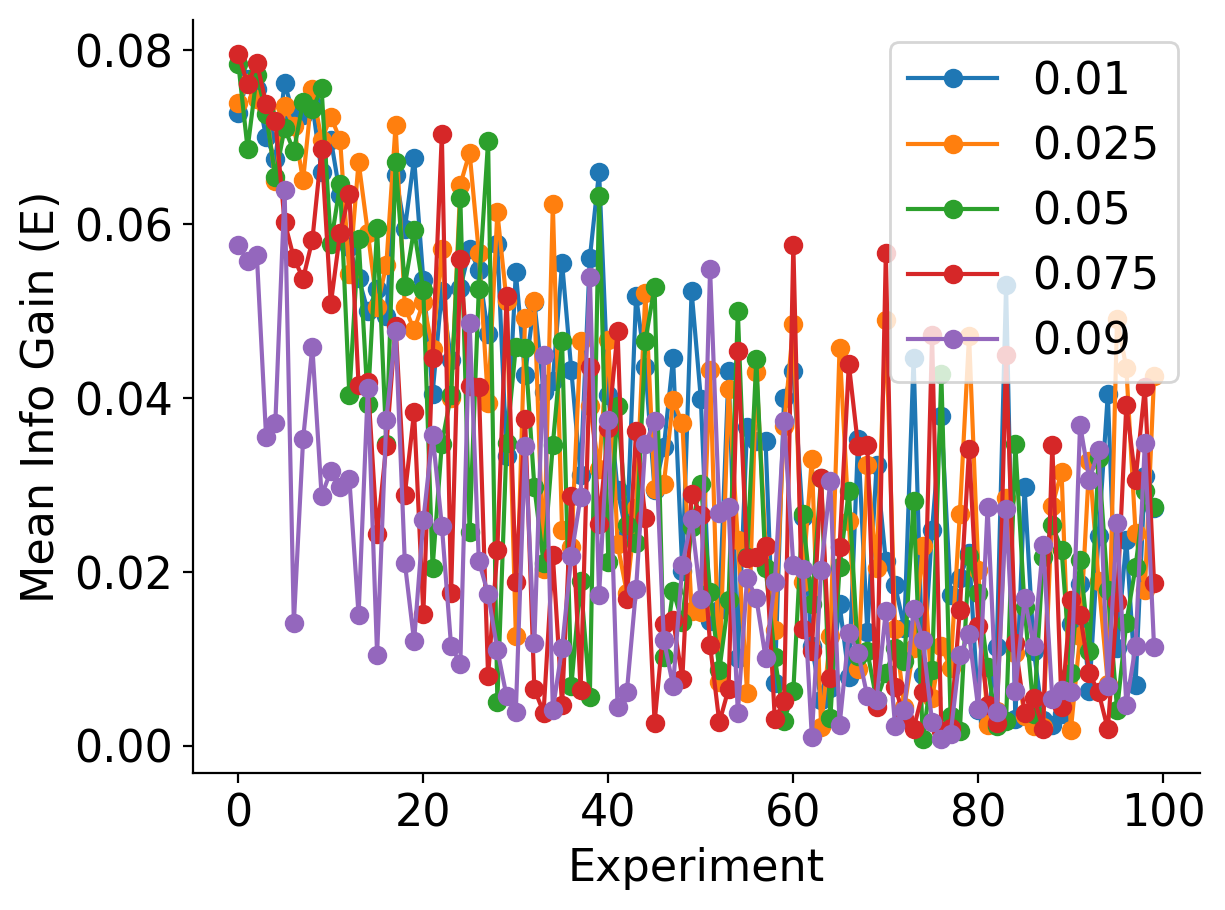

In [29]:
# Score
scores = []
for result in results:
    b = []
    for r in result:
        b.append(np.mean(r["agent_info_gain"]))

    scores.append(b)

steps = np.reshape(scores, (len(thresholds), num_experiments))

# Create the x values for the plot
x = np.arange(len(names))

# Plotting each row of the array as a separate line
for i in range(len(steps)):
    plt.plot(steps[i], marker='o', label=f'{thresholds[i]}')

# Add legend
plt.legend()

plt.ylabel("Mean Info Gain (E)")
plt.xlabel("Experiment")
plt.tight_layout()
sns.despine()

Next we will look at the average performance on a variety of measures as we vary the threshold.

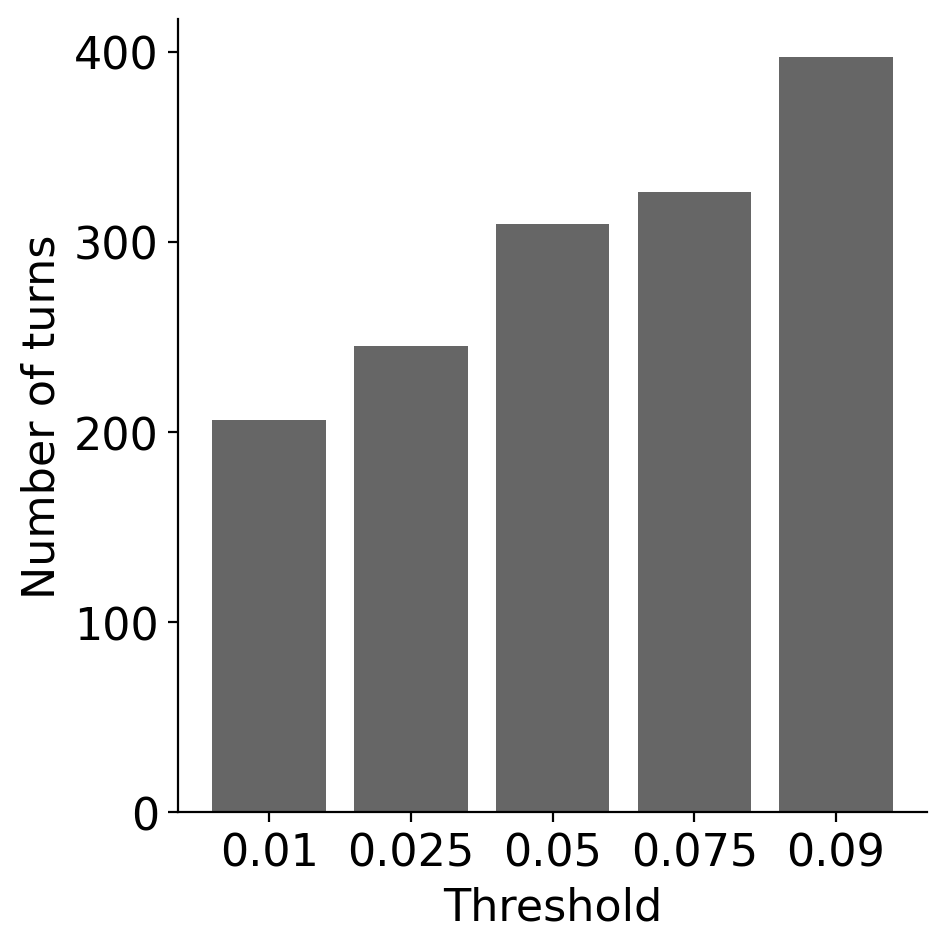

In [30]:
# Score
scores = []
for result in results:
    l = 0.0
    for r in result:
        l += max(r["agent_num_turn"])
    l = l / len(result)
    scores.append(l)

# Tabulate
m, sd = [], []
for s in scores:
    m.append(np.mean(s))

# -
fig = plt.figure(figsize=(5, 5))
plt.bar([str(n) for n in names], m, color="black", alpha=0.6)
plt.ylabel("Number of turns")
plt.xlabel("Threshold")
plt.tight_layout()
sns.despine()

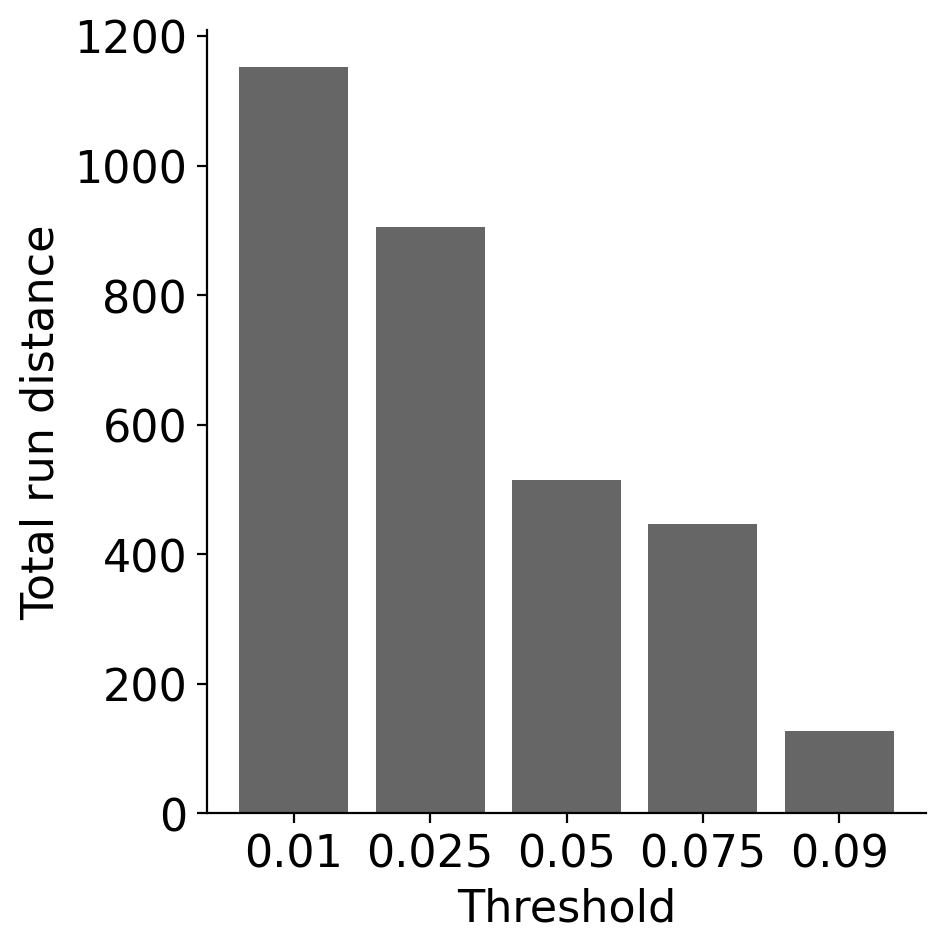

In [31]:
# Score
scores = []
for result in results:
    l = 0.0
    for r in result:
        l += np.sum(r["agent_num_step"])
    l = l / len(result)
    scores.append(l)

# Tabulate
m, sd = [], []
for s in scores:
    m.append(np.mean(s))

# -
fig = plt.figure(figsize=(5, 5))
plt.bar([str(n) for n in names], m, color="black", alpha=0.6)
plt.ylabel("Total run distance")
plt.xlabel("Threshold")
plt.tight_layout()
sns.despine()

num_death:   0%|          | 0/100 [00:00<?, ?it/s]

num_death:   0%|          | 0/100 [00:00<?, ?it/s]

num_death:   0%|          | 0/100 [00:00<?, ?it/s]

num_death:   0%|          | 0/100 [00:00<?, ?it/s]

num_death:   0%|          | 0/100 [00:00<?, ?it/s]

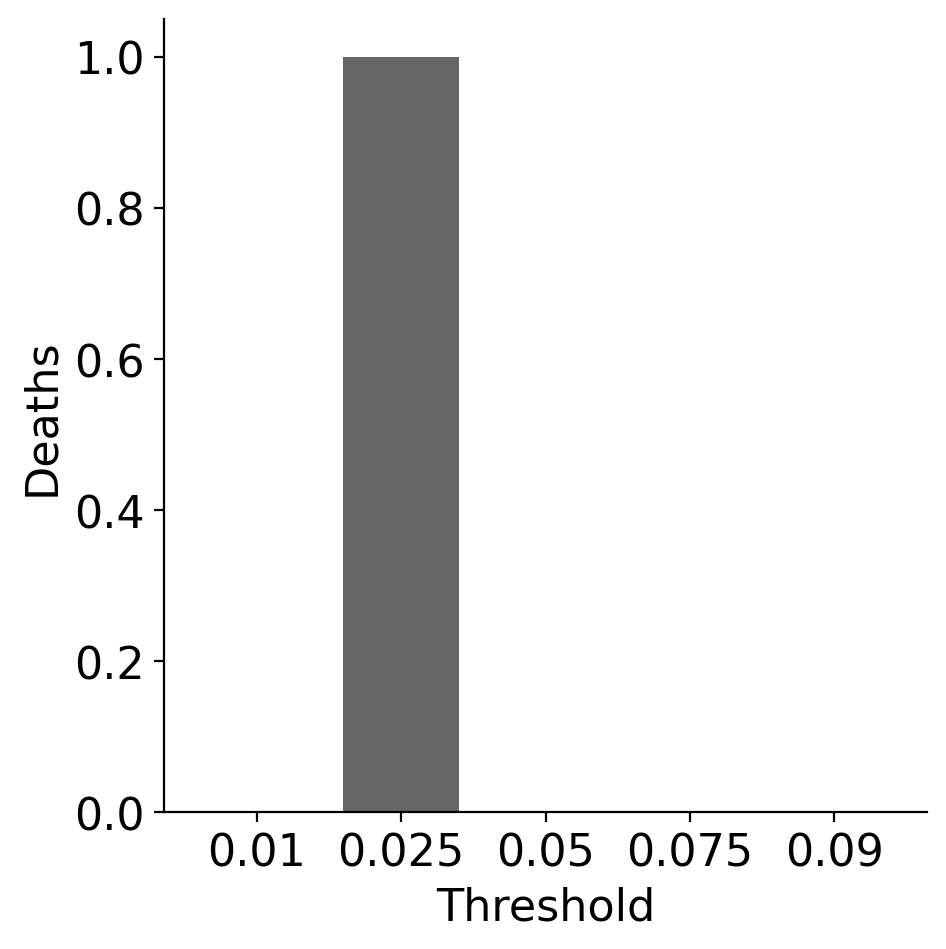

In [32]:
# Score
scores = []
for result in results:
    scores.append(num_death(result))

# -
fig = plt.figure(figsize=(5, 5))
plt.bar([str(n) for n in names], scores, color="black", alpha=0.6)
plt.ylabel("Deaths")
plt.xlabel("Threshold")
plt.tight_layout()
sns.despine()

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

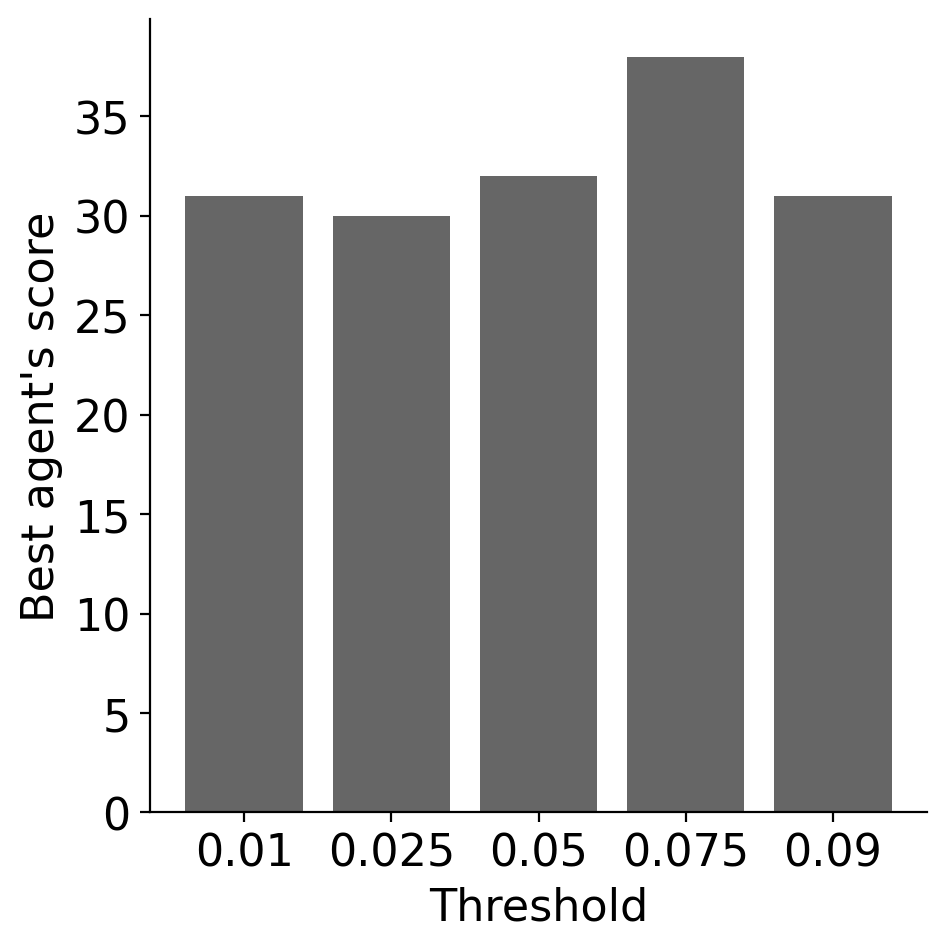

In [33]:
# Max Score
scores = []
for result in results:
    r = total_reward(result)
    scores.append(r)

# Tabulate
m = []
for s in scores:
    m.append(np.max(s))

# -
fig = plt.figure(figsize=(5, 5))
plt.bar([str(n) for n in names], m, color="black", alpha=0.6)
plt.ylabel("Best agent's score")
plt.xlabel("Threshold")
plt.tight_layout()
sns.despine()

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

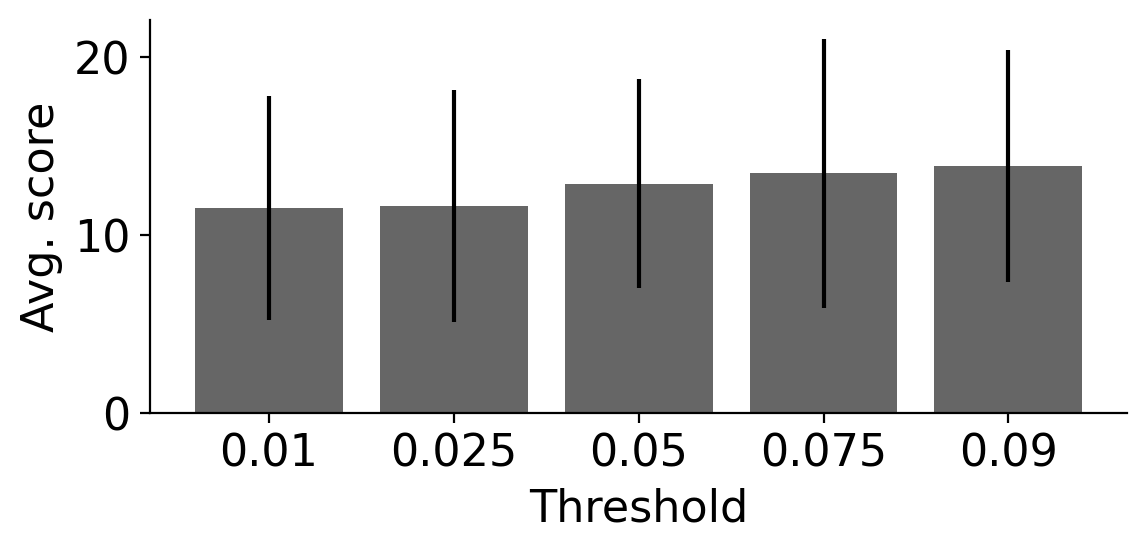

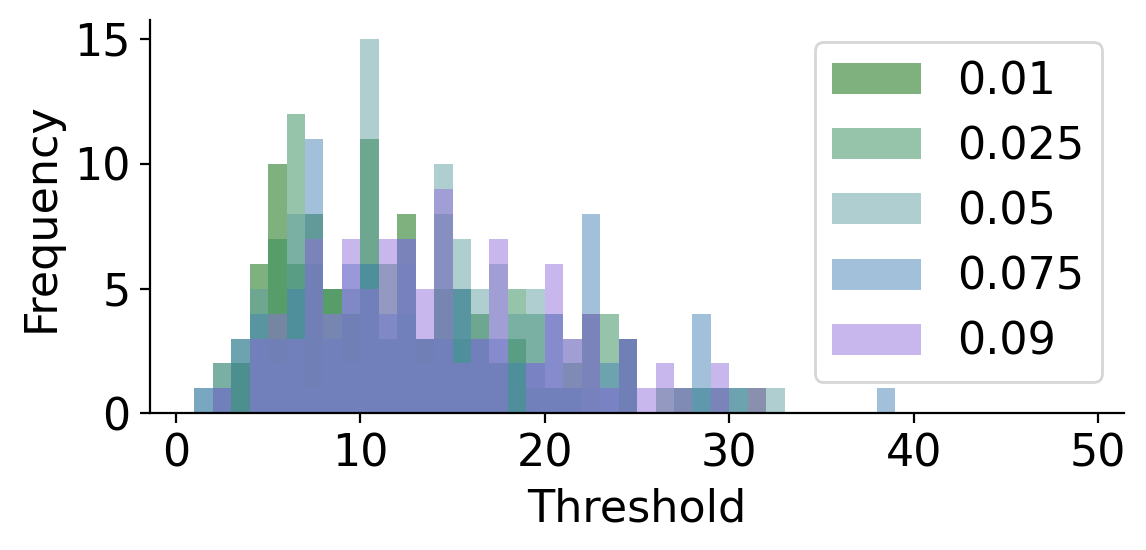

In [34]:
# Score
scores = []
for result in results:
    r = total_reward(result)
    scores.append(r)

# Tabulate
m, sd = [], []
for s in scores:
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(6, 3))
plt.bar([str(n) for n in names], m, yerr=sd, color="black", alpha=0.6)
plt.ylabel("Avg. score")
plt.xlabel("Threshold")
plt.tight_layout()
sns.despine()

# Dists of means
fig = plt.figure(figsize=(6, 3))
for (i, s, c) in zip(names, scores, colors):
    plt.hist(s, label=i, color=c, alpha=0.5, bins=list(range(1,50,1)))
    plt.legend()
    plt.ylabel("Frequency")
    plt.xlabel("Threshold")
    plt.tight_layout()
    sns.despine()

---
### Question 2.1

How does increasing the *threshold* impact our Info agent's performance? Explain why this particular pattern emerges in the results.

__Answer:__

1. As the threshold increases (from 0.01 to 0.09), **the mean information gain decreases** more quickly as the agent runs through the experiments. This is expected because agents with a higher threshold are more selective, thus gathering less information over time. With higher thresholds, the agent becomes more conservative, only reacting to significant changes in information gain, which results in lower average information gain overall.

2. **The number of turns increases** as the threshold increases. This indicates that at higher thresholds, the agent is making more decisions based on larger jumps in information gain. This pattern is likely because a higher threshold causes the agent to wait longer to make a decision, leading to fewer total steps but potentially more significant turns.

3. **The total run distance decreases** as the threshold increases. Lower thresholds cause the agent to move more because it reacts more often to small changes in the environment. As the threshold increases, the agent makes fewer movements, resulting in a shorter overall distance traveled. Higher thresholds result in more strategic movements rather than frequent reactive movements.

4. The number of deaths is highest at the 0.025 threshold, and **there are no deaths at the highest thresholds** (0.075 and 0.09). At lower thresholds (for example, 0.025), the agent’s over-sensitivity might lead it into inefficient paths, potentially leading to more deaths. Higher thresholds seem to reduce risky decisions and thus prevent deaths, suggesting that more conservative movement strategies are safer.

5. The agent achieves the highest reward at the 0.075 threshold. **The score dips slightly** at both lower (0.01) and **higher (0.09) thresholds.** At very low thresholds, the agent reacts too much to minor changes and misses the bigger picture. At very high thresholds, the agent misses opportunities to optimize its path due to its cautiousness. Thus, the optimal threshold for achieving the best reward is around 0.075, as the agent balances exploration and exploitation more effectively.

6. **There is a slight increase in the average score** as the threshold increases. This pattern is likely because the agent is becoming more efficient at filtering noise and making better decisions.

Overall, lower thresholds lead to higher reactivity and more movement, but the agent is inefficient in gathering useful information or avoiding deaths. On the other hand, higher thresholds reduce movement, minimize deaths, but the agent may miss important cues in the environment.

---
### Question 2.2

Take the results from the two sections together. Compare the infotaxis agent with the random search or chemotaxis agent. What does this tell you about the nature of curious search?

__Answer:__

The infotaxis agent makes decisions based on how much information it gains from the environment. It seeks to maximize information gain rather than simply following a gradient or wandering randomly. In section 1, we saw that the infotaxis agent performed better than the random agent but was outperformed by the chemotaxis agent in terms of total reward. In section 2, the infotaxis agent’s performance was highly dependent on the threshold value.

The random agent searches randomly without relying on any information about its environment. It is a baseline agent, representing unstructured exploration. The random agent performed the worst across most metrics. It had the shortest total run distance, the lowest total reward, and the least efficient search strategy. The randomness resulted in inefficient exploration, as the agent was not guided by any cues or information from the environment.

The chemotaxis agent follows a straightforward strategy: it moves up or down a scent gradient. It responds directly to changes in the gradient. This agent consistently outperformed both the infotaxis and random agents in total reward. It covered more distance and made more efficient decisions based on the environmental gradient. This direct responsiveness to environmental cues allowed it to excel in environments where the scent gradient was reliable.

That said, I think the infotaxis agent (representing curious search) performs well in environments where information is not directly available or where the agent needs to learn more before making decisions. It balances between exploration and exploitation, making it more adaptable in uncertain environments compared to rigid strategies like chemotaxis or random search. However, in simple environments with clear, reliable signals, following a direct gradient (chemotaxis) may be more efficient. This shows that curiosity-driven exploration is particularly useful when the agent needs to navigate complex or noisy environments, where simple gradient-following is less effective.


---
**IMPORTANT** Did you collaborate with anyone on this assignment, or use LLMs like ChatGPT? If so, list their names here.
> *Write Name(s) here*